In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm import tqdm

# Building the Dataset

In [23]:
import os
import shutil
import random
from tqdm import tqdm

# Path to the dataset containing audio samples
data_dir = "/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches"  # Modify this path if needed

# Retrieve all available speaker directories
speaker_folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Choose a specific speaker for classification
target_speaker = "Julia_Gillard"

# Define directories for categorized data
speaker_output = "speaker"
non_speaker_output = "non_speaker"

# Ensure the output folders exist
os.makedirs(speaker_output, exist_ok=True)
os.makedirs(non_speaker_output, exist_ok=True)

# Process and copy files to appropriate categories
for speaker in speaker_folders:
    source_path = os.path.join(data_dir, speaker)
    destination = speaker_output if speaker == target_speaker else non_speaker_output
    print(f"Transferring files from {speaker} to {destination}...")

    for audio_file in tqdm(os.listdir(source_path)):
        audio_path = os.path.join(source_path, audio_file)
        if os.path.isfile(audio_path):  # Confirm it's an actual file
            renamed_file = f"{speaker}_{audio_file}"  # Prefix filename with folder name
            shutil.copy(audio_path, os.path.join(destination, renamed_file))

print(f"Files from '{target_speaker}' stored in '{speaker_output}'.")
print(f"Other speakers categorized under '{non_speaker_output}' with prefixed filenames.")

Transferring files from Nelson_Mandela to non_speaker...


100%|██████████| 1500/1500 [00:03<00:00, 387.34it/s]


Transferring files from Benjamin_Netanyau to non_speaker...


100%|██████████| 1500/1500 [00:04<00:00, 354.79it/s]


Transferring files from other to non_speaker...


100%|██████████| 2/2 [00:00<00:00, 92.40it/s]


Transferring files from _background_noise_ to non_speaker...


100%|██████████| 4/4 [00:00<00:00, 95.29it/s]


Transferring files from Magaret_Tarcher to non_speaker...


100%|██████████| 1500/1500 [00:04<00:00, 364.75it/s]


Transferring files from Jens_Stoltenberg to non_speaker...


100%|██████████| 1500/1500 [00:04<00:00, 352.21it/s]


Transferring files from Julia_Gillard to speaker...


100%|██████████| 1501/1501 [00:04<00:00, 363.37it/s]

Files from 'Julia_Gillard' stored in 'speaker'.
Other speakers categorized under 'non_speaker' with prefixed filenames.


In [24]:
import tensorflow as tf
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

# Define dataset directory
data_root = "/kaggle/working/"

# Categories for classification
categories = ["speaker", "non_speaker"]

# Define a fixed MFCC feature shape
FIXED_MFCC_LENGTH = 50  # Adjust as needed based on average length of features

def load_audio_features(data_root, categories):
    """Extracts MFCC features and assigns labels to audio files."""
    feature_list = []
    label_list = []

    for label_idx, category in enumerate(categories):
        category_path = os.path.join(data_root, category)

        for file in tqdm(os.listdir(category_path)):
            if file.endswith(".wav"):
                file_path = os.path.join(category_path, file)
                audio_signal, sample_rate = librosa.load(file_path, sr=None, duration=1)
                
                # Compute MFCC features
                mfcc_features = librosa.feature.mfcc(y=audio_signal, sr=sample_rate, n_mfcc=13)
                
                # Standardize features
                mfcc_features = StandardScaler().fit_transform(mfcc_features)
                
                # Pad or truncate MFCCs to FIXED_MFCC_LENGTH
                if mfcc_features.shape[1] < FIXED_MFCC_LENGTH:
                    pad_width = FIXED_MFCC_LENGTH - mfcc_features.shape[1]
                    mfcc_features = np.pad(mfcc_features, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfcc_features = mfcc_features[:, :FIXED_MFCC_LENGTH]  # Truncate if too long
                
                feature_list.append(mfcc_features.T)  # Transpose to match shape
                label_list.append(label_idx)

    return np.array(feature_list), np.array(label_list)

# Load extracted features and corresponding labels
X, y = load_audio_features(data_root, categories)

print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")


100%|██████████| 6006/6006 [00:44<00:00, 135.29it/s]

Feature shape: (7507, 50, 13), Labels shape: (7507,)


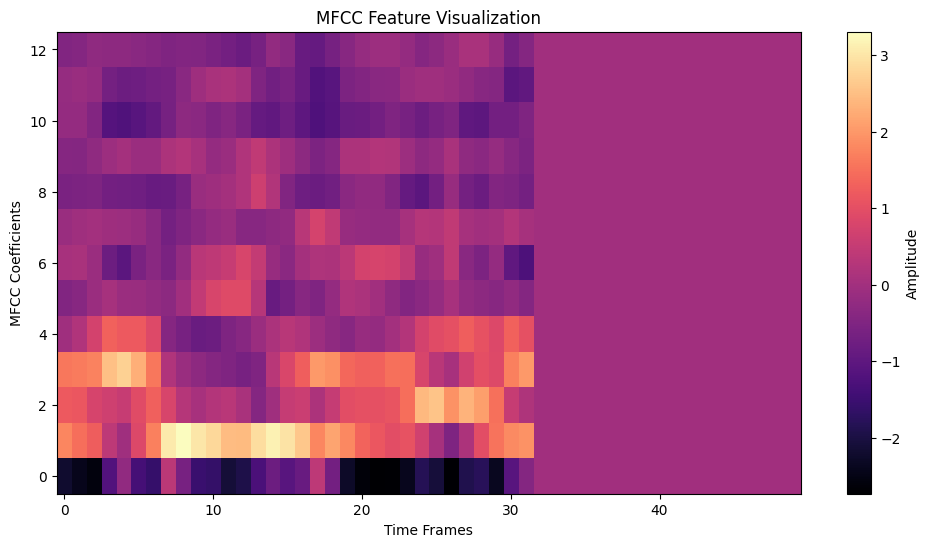

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the first feature sample
first_feature = X[0].T  # Transpose to (MFCC Coefficients, Time Frames)

# Plot the MFCC features
plt.figure(figsize=(12, 6))
plt.imshow(first_feature, aspect='auto', cmap='magma', origin='lower')

# Add colorbar for better visualization
plt.colorbar(label="Amplitude")

# Labels and title
plt.title("MFCC Feature Visualization")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

# Show the plot
plt.show()


In [40]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize and apply label encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
encoder.classes_ = np.array(speaker_folders)  # Explicitly set class labels

# Split dataset into training, validation, and test sets
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Display dataset dimensions
print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")


Training Set: (5254, 50, 13)
Validation Set: (1126, 50, 13)


In [27]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Define model-building function for tuning
def build_model(hp):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(units=hp.Int('units', min_value=64, max_value=256, step=32), 
                                   input_shape=(X_train.shape[1], X_train.shape[2])))
    
    model.add(tf.keras.layers.Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    
    # Output layer
    model.add(tf.keras.layers.Dense(len(speaker_folders), activation='softmax'))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize Keras Tuner with Hyperband search
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',  
    max_epochs=10,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='speaker_classification'
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Run the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stop])

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameter combination
print(f"Best LSTM Units: {best_hps.get('units')}")
print(f"Best Dense Units: {best_hps.get('dense_units')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

# Build the best model with tuned hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stop])

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Reloading Tuner from hyperparameter_tuning/speaker_classification/tuner0.json
Best LSTM Units: 128
Best Dense Units: 32
Best Learning Rate: 0.0005
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.8100 - loss: 0.8184 - val_accuracy: 0.9307 - val_loss: 0.1905
Epoch 2/20
  9/165 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.8841 - loss: 0.2450

KeyboardInterrupt: 

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8039 - loss: 0.8759 - val_accuracy: 0.8162 - val_loss: 0.3724
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9263 - loss: 0.1890 - val_accuracy: 0.9156 - val_loss: 0.2070
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9260 - loss: 0.1786 - val_accuracy: 0.9813 - val_loss: 0.0648
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9922 - loss: 0.0325 - val_accuracy: 0.9831 - val_loss: 0.0524
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9873 - loss: 0.0351 - val_accuracy: 0.9840 - val_loss: 0.0371
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9915 - loss: 0.0266 - val_accuracy: 0.9920 - val_loss: 0.0365
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9955 - loss: 0.0135 - val_accuracy: 0.9831 - val_loss: 0.0747
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9941 - loss: 0.0174 - val_acc

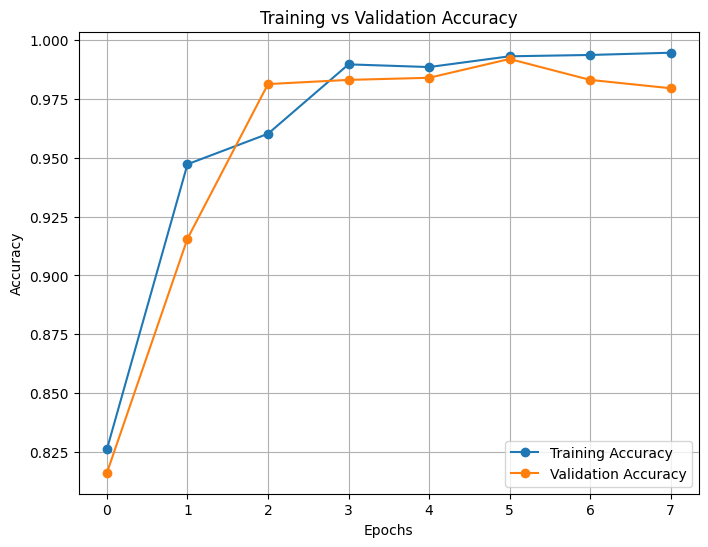

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Build the model using the best hyperparameters
final_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

# Compile the model
final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
final_history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

# Evaluate on test data
test_loss, test_acc = final_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Save the trained model
final_model.save("best_speaker_model.h5")

# Plot training & validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(final_history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(final_history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Test Accuracy: 0.9902
Weighted F1 Score: 0.9902


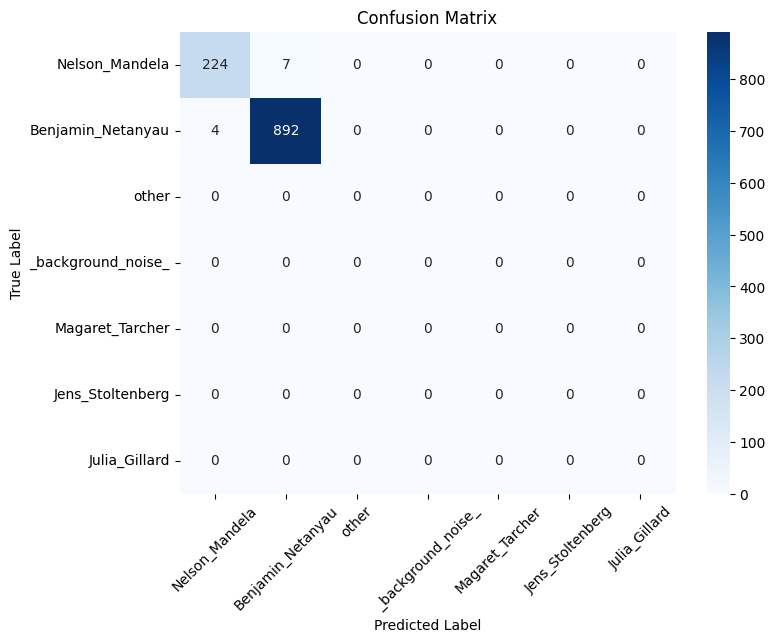

In [43]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Load the trained model
final_model = tf.keras.models.load_model("best_speaker_model.h5")

# Make predictions
y_pred_prob = final_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Compute accuracy
test_accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.show()


In [46]:
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load the pre-trained model
model = tf.keras.models.load_model("best_speaker_model.h5")

def classify_audio(file_path, model, label_encoder):
    """Processes an audio file and predicts its class."""
    # Load the audio clip
    audio_data, sample_rate = librosa.load(file_path, sr=None, duration=1)

    # Extract and normalize MFCC features
    mfcc_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
    mfcc_features = StandardScaler().fit_transform(mfcc_features)

    # Reshape to fit model input requirements
    mfcc_features = mfcc_features.T[np.newaxis, ...]

    # Get predictions
    predictions = model.predict(mfcc_features)
    predicted_index = np.argmax(predictions, axis=1)

    # Convert index to class label
    predicted_label = label_encoder.inverse_transform(predicted_index)

    return predicted_label[0]

# Example usage
test_audio = "/kaggle/working/non_speaker/Benjamin_Netanyau_7.wav"
result = classify_audio(test_audio, model, label_encoder)
if(result != target_speaker):
    print(f"Non-Speaker: {result}")
else:
    print(f"Speaker: {result}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Non-Speaker: Benjamin_Netanyau
